In [1]:
import os, random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import InterfacePreprocessing as IntPre

from PIL import Image
from scipy.ndimage import imread
from scipy.misc import imresize
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [7]:
# Create the same image merge with maximum 3 kind of pre-processing
def preprocessing_bare(image, size):
    
    if raw_only:
        image_temp = np.zeros((size,size,1))
        image = imresize(image, [size, size])
        image_temp[:,:,0] = image
    else:
        image_temp = np.zeros((size,size,4))
        image = imresize(image, [size, size]).astype(np.int32)
        image_temp[:,:,0] = image # 180*180
        image_temp[:,:,1] = imresize(IntPre.frequency(image, step=5), [size, size])
        image_temp[:,:,2] = imresize(np.abs(IntPre.orientation(image, coherence=False)), [size, size])
        image_temp[:,:,3] = imresize(IntPre.variance(image, block=5), [size, size])
        
#        OrMap = np.abs(IntPre.orientation(image, coherence=False))
#        Image.fromarray(255.0*(OrMap-np.min(OrMap))/np.max(OrMap)).show()
        
    return image_temp

# To load images like CASIA (no matching etc...)
def load_vrac(path):
    images = dict()

    for f in os.listdir(path):
        ID = f[:-4]
        image = imread(path+f).astype(np.int32)
        image_temp = preprocessing_bare(image, raw_image_size)
        images[ID] = image_temp
    return images

# To load images organised by pairs (of match and mismatch)
def load_pairs(path_match, path_mismatch):
    return load_vrac(path_match), load_vrac(path_mismatch)

In [3]:
# # If images are loaded with "load_pairs"
# def generate_batch_pairs(images_match, images_mismatch, num, image_size):
        
#     x = np.zeros((num, image_size*image_size*num_layer))
#     x_p = np.zeros((num, image_size*image_size*num_layer))
#     y = np.zeros((num, 1))
#     match = int(np.round(num*0.5))
#     mis_match = num - match

#     keys_mismatch = images_mismatch.keys()
#     for i in range(mis_match):
#         ID = random.choice(keys_mismatch)[:-1]
#         img = images_mismatch[ID + '0']
#         img_p = images_mismatch[ID + '1']
#         x[i,:] = np.reshape(img, (1,image_size*image_size*num_layer))
#         x_p[i,:] = np.reshape(img_p, (1,image_size*image_size*num_layer))
#         y[i] = 0

#     keys_match = images_match.keys()
#     for i in range(match):
#         ID = random.choice(keys_match)[:-1]
#         img = images_match[ID + '0']
#         img_p = images_match[ID + '1']
#         x[mis_match+i,:] = np.reshape(img, (1,image_size*image_size*num_layer))
#         x_p[mis_match+i,:] = np.reshape(img_p, (1,image_size*image_size*num_layer))
#         y[mis_match+i] = 1

# #     # Below just for testing!!!
# #     keys_mismatch = images_mismatch.keys()
# #     for i in range(num):
# #         ID = random.choice(keys_mismatch)[:-1]
# #         img = images_match[ID+'0']
# #         img_shifted = np.copy(img)
        
# #         img_shifted = np.rot90(img_shifted)
# # #         for h in range(img.shape[0]):
# # #             for w in range(img.shape[0]-10):
# # #                 img_shifted[h,w] = img_shifted[h,w+30]
                
# #         x[mis_match+i,:] = np.reshape(img, (1,image_size*image_size*4))
# #         x_p[mis_match+i,:] = np.reshape(img_shifted, (1,image_size*image_size*4))
# #         y[mis_match+i] = 0   
        
        
#     return [x, x_p, y]

In [4]:
# If images are loaded with "load_pairs"
def generate_batch_pairs(images_match, images_mismatch, num, image_size):
        
    x = np.zeros((num, image_size*image_size*num_layer))
    x_p = np.zeros((num, image_size*image_size*num_layer))
    y = np.zeros((num, 1))
    match = int(np.round(num*0.5))
    mis_match = num - match

    keys_mismatch = images_mismatch.keys()
    for i in range(mis_match):
        ID = random.choice(keys_mismatch)[:-1]
        img = images_mismatch[ID + '0']
        x1 = img[:88,:88,:]
        x2 = img[4:92,:88,:]
        x[i,:] = np.reshape(x1, (1,image_size*image_size*num_layer))
        x_p[i,:] = np.reshape(x2, (1,image_size*image_size*num_layer))
        y[i] = 0

    keys_match = images_match.keys()
    for i in range(match):
        ID = random.choice(keys_match)[:-1]
        img = images_match[ID + '0']
        x1 = img[:88,:88,:]
        x2 = img[88:176,:88,:]      
        x[mis_match+i,:] = np.reshape(x1, (1,image_size*image_size*num_layer))
        x_p[mis_match+i,:] = np.reshape(x2, (1,image_size*image_size*num_layer))
        y[mis_match+i] = 1

#     # Below just for testing!!!
#     keys_mismatch = images_mismatch.keys()
#     for i in range(num):
#         ID = random.choice(keys_mismatch)[:-1]
#         img = images_match[ID+'0']
#         img_shifted = np.copy(img)
        
#         img_shifted = np.rot90(img_shifted)
# #         for h in range(img.shape[0]):
# #             for w in range(img.shape[0]-10):
# #                 img_shifted[h,w] = img_shifted[h,w+30]
                
#         x[mis_match+i,:] = np.reshape(img, (1,image_size*image_size*4))
#         x_p[mis_match+i,:] = np.reshape(img_shifted, (1,image_size*image_size*4))
#         y[mis_match+i] = 0   
        
        
    return [x, x_p, y]

In [5]:
def weight_variable(shape):
    initial = tf.constant(0.3, shape=shape)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.3, shape=shape)
    return tf.Variable(initial)

def assist_variable(shape):
    initial = tf.constant(0.3, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride=[1, 1, 1, 1]):
    return tf.nn.conv2d(x, W, strides=stride, padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
def sigm(x):
    return tf.sigmoid(x)

In [8]:
# The three variables below are global variables and they can be read everywhere

global raw_only, image_size, num_layer
raw_only = False
raw_image_size = 180
image_size= 88
if raw_only:
    num_layer = 1
else:
    num_layer = 4

p_matching = 0.5
num_filter_1 = 16
num_filter_2 = 64
num_filter_3 = 256

# images = load_vrac('/home/cedric/Bureau/Sample/')
images_match, images_mismatch = load_pairs("./PAIRS/MATCHED/CROP/", "./PAIRS/MISMATCHED/CROP/")

# Creating a new TF session

In [9]:
sess = tf.InteractiveSession()

# These two are input images
x = tf.placeholder(tf.float32, shape=[None, image_size*image_size*num_layer])
x_p = tf.placeholder(tf.float32, shape=[None, image_size*image_size*num_layer])

# y_ is just a value 0(match) or 1(no match) for the two input images
y_ = tf.placeholder(tf.float32, shape=[None, 1])

# Dropout coefficient
keep_prob = tf.placeholder(tf.float32)

sess.run(tf.initialize_all_variables())

# Defining Shared Weights

In [10]:
W_conv1 = weight_variable([7, 7, num_layer, num_filter_1])
b_conv1 = bias_variable([num_filter_1])

W_conv2 = weight_variable([5, 5, num_filter_1, num_filter_2])
b_conv2 = bias_variable([num_filter_2])

W_conv3 = weight_variable([5, 5, num_filter_2, num_filter_3])
b_conv3 = bias_variable([num_filter_3])

W_conv1_p = weight_variable([7, 7, num_layer, num_filter_1])
b_conv1_p = bias_variable([num_filter_1])

W_conv2_p = weight_variable([5, 5, num_filter_1, num_filter_2])
b_conv2_p = bias_variable([num_filter_2])

W_conv3_p = weight_variable([5, 5, num_filter_2, num_filter_3])
b_conv3_p = bias_variable([num_filter_3])

# Two Sides of Siamese Net

In [11]:
# Side 1
# Input Image
x_image = tf.reshape(x, [-1,image_size,image_size,num_layer])

# First Conv Layer
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second Conv Layer
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Third Conv Layer
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# Final Data Processing Step
z = tf.reshape(h_pool3, [-1,30976])
z_norm = tf.pow(tf.reduce_sum(tf.pow(z, 2), reduction_indices=1),0.5)

# Side 2
# Input Image
x_image_p = tf.reshape(x_p, [-1,image_size,image_size,num_layer])

# First Conv Layer - after maxpool 44*44
h_conv1_p = tf.nn.relu(conv2d(x_image_p, W_conv1_p) + b_conv1_p)
h_pool1_p = max_pool_2x2(h_conv1_p)

# Second Conv Layer - after maxpool 22*22
h_conv2_p = tf.nn.relu(conv2d(h_pool1_p, W_conv2_p) + b_conv2_p)
h_pool2_p = max_pool_2x2(h_conv2_p)

# Second Conv Layer - after maxpool 22*22
h_conv3_p = tf.nn.relu(conv2d(h_pool2_p, W_conv3_p) + b_conv3_p)
h_pool3_p = max_pool_2x2(h_conv3_p)

# Final Data Processing Step
z_p = tf.reshape(h_pool3_p, [-1,30976])
z_p_norm = tf.pow(tf.reduce_sum(tf.pow(z_p, 2), reduction_indices=1),0.5)

# Simple Fully Connected Layer

In [12]:
# dz = z - z_p

# # First flatten it
# dz_flat = tf.reshape(dz, [-1,22*22*num_filter_2])

# y_fc1 = tf.nn.softmax(tf.matmul(dz_flat, W_fc1) + b_fc1)

# keep_prob = tf.placeholder(tf.float32)
# h_fc2_drop = tf.nn.dropout(y_fc1, keep_prob)

# y_readout = tf.nn.softmax(tf.matmul(h_fc2_drop, W_fc2) + b_fc2)

# Actual Calculation

In [13]:
cross_entropy = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm)

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.round(tf.mul(z, z_p)/tf.reduce_prod(z_norm*z_p_norm)), y_)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.initialize_all_variables())

for i in range(500):
    batch = generate_batch_pairs(images_match, images_mismatch, 50, image_size)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})

# batch = generate_batch_pairs(images_match, images_mismatch, 200, image_size)
# batch = simul_siamese(batch)

# print("Accuracy %g"%accuracy.eval(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0}))

# results = y_readout.eval(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})[:,1]
# from PIL import Image
#     im = im.resize((newSize,newSize),Image.ANTIALIAS)show_ROC(batch[2][:,1], results)

step 0, training accuracy 0.5


KeyboardInterrupt: 

[ 0.99988186  0.99992222  0.99337518  0.96889216]
[[ 0.]
 [ 0.]
 [ 1.]
 [ 1.]]


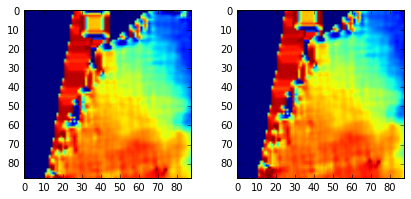

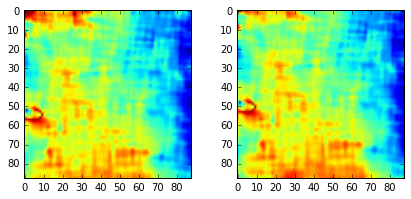

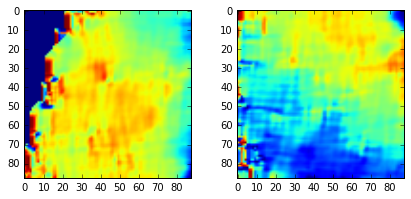

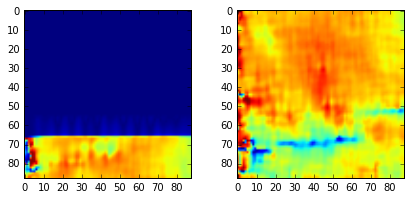

In [16]:
num=4
batch = generate_batch_pairs(images_match, images_mismatch, num, image_size)

# print("Accuracy %g" %accuracy.eval(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0}))

for i in range(num):
    plt.figure(figsize=(7,3))
    ax = plt.subplot(1,2,1)
    ax.imshow(np.reshape(batch[0][i], (88,88,4))[:,:,2])
    ax = plt.subplot(1,2,2)
    ax.imshow(np.reshape(batch[1][i], (88,88,4))[:,:,2])

results = cross_entropy.eval(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})

print results
print batch[2]

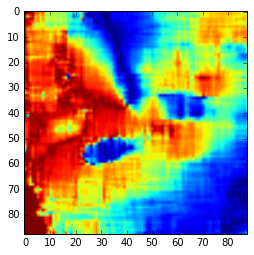

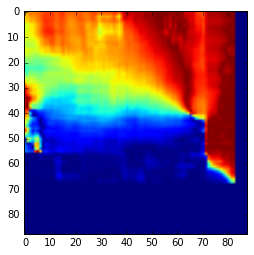

In [15]:
path = "./PAIRS/MATCHED/CROP/"
counter = 0
for f in os.listdir(path):
    counter+=1
    ID = f[:-4]
    image = imresize(imread(path+f), [88, 88]).astype(np.int32)
#     plt.imshow(image)
    plt.figure()
    plt.imshow(np.abs(IntPre.orientation(image, coherence=False)))
    if counter > 1:
        break

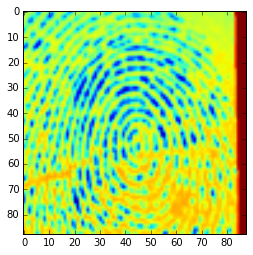

In [159]:
plt.imshow(imresize(image, [88, 88]))

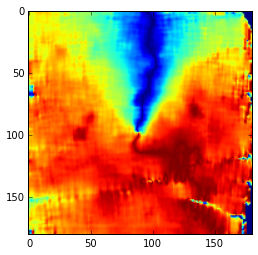

In [165]:
plt.imshow(np.abs(IntPre.orientation(images_mismatch[images_mismatch.keys()[0]][:,:,0], coherence=False)))